In [1]:
import pymc3 as pm
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from arviz.utils import Numba
Numba.disable_numba()
Numba.numba_flag

C:\Users\user\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\user\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\user\anaconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


False

In [ ]:
# AB테스트를 하는 과정에서 손실이 일어날 수 있는데 손실을 최적화하는 방법은?

# 활용exploitation : 자신이 알고 있는 최적의 행동을 함으로써 이익을 높이는 것
# 탐색exploration : 지식을 늘리기 위해 새로운 행동을 시도

# ==>탐색과 활용의 틸레마 exploration-exploitation dilemma

# 다중 슬롯머신 문제 multi-armed bandit problem : 탐색과 활용의 딜레마를 안고 있는 문제를 다루는 전형적인 방법
# 여러개의 슬롯머신이 있을 때 어느 슬롯머신에 배팅할 것인가? 
# 여기서는 확률적 슬롯머신 문제를 다룸. 솔루션을 선택했을 때의 보상이 어떤 확률 분포에 따라 주어진다고 가정하며, 누적 보상을 최대화 하고자 함.
# 에이전트agent : 최적의 솔루션을 찾아내는 주체. 총 T 횟수만큼 다양한 솔루션을 시도.
# 환경environment : 에이전트와 대치하는 대상 전체
# T: 예산. 횟수 상한선. 1 <= t <= T 는 '시각'이라고 부름
# x(t) : t번째 횟수에 선택한 솔루션
# r(t) : t번째 횟수에 얻은 보상 (웹사이트 최적화의 경우 클릭 유무)
# R(t) : 누적 보상. 이를 최대화하는 전략, 즉 방책을 구하는 것이 확률적 슬롯머신 문제

# 슬롯머신 알고리즘의 성능은 많은 횟수를 시뮬레이션한 결과를 바탕으로 누적 보상 기댓값을 계산에 평가함. 누적 보상 기닷값이 이상적인 방책에 얼마나 가까운지를 평가.
# 이상적인 방책이란 항상 기댓값이 최고인 솔루션을 계속 선택하는 가상의 방책
# 후회regret : 이상적인 방책과 누적 보상의 차이. 


# epsilon-greedy 알고리즘: 슬롯머신 알고리즘 중 가장 간단한 알고리즘.
# 어떤 작은 확률 e으로 탐색, 1 - e 로 활용 행동을 취하는 것. 
# 탐색 행동을 선택한 경우에는 솔루션을 무작위로 선택
# 활용 행동ㅇ르 선택한 경우에는 그 시점에서 얻어진 보상의 표본 평균이 최대인 솔루션 x*(t)를 선택


In [2]:
# epsilon-greedy 알고리즘 구현하기:
# 보상 r : 성공확률에 따라 0 또는 1의 값
# 각 솔루션의 성공 확률: theta1 = 0.1, theta2 = 0.2, theta3 = 0.3, theta4 = 0.3
# 분제의 최적의 솔루션 : x* = x4

import numpy as np
np.random.seed(0)
n_arms = 4  #솔루션 수 K = 4

class Env(object):
    thetas = [0.1, 0.1, 0.2, 0.3]
    
    def react(arm):
        return 1 if np.random.random() < Env.thetas[arm] else 0
    
    def opt():  #전지전능한 에이전트 외에는 이 메서드 호출할 수 없음
        return np.argmax(Env.thetas)

In [3]:
class EpsilonGreedyAgent(object):
    
    def __init__(self, epsilon=0.1):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)  # 각 솔루션을 선택한 횟수 N(t)
        self.values = np.zeros(n_arms)  # 각 솔루션으로부터 얻은 보상의 표본 평균 theta{t}
        
    def get_arm(self):
        # 알고리즘에 기반해 적절한 솔루션 선택.
        if np.random.random() < self.epsilon:  # 균일 분포로 생성한 난수가 self.epsilon보다 작으면 탐색 행동 => 무작위 솔루션 선택
            arm = np.random.randint(n_arms)
        else:  # 균일 분포로 생성한 난수가 self.epsilon보다 크면 활용 행동 => 보상의 표본 평균이 가장 큰 솔루션 선택
            arm = np.argmax(self.values)
        return arm
    
    def sample(self, arm, reward):
        # 각 솔루션을 선택한 횟수 self.counts와 각 솔루션의 표본 평균 self.values를 업데이트
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm] - 1) * self.values[arm] + reward
            ) / self.counts[arm]
        

In [4]:
def sim(Agent, N=1000, T=1000, **kwargs):  # 평가할 에이전트의 클래스 Agent, 시뮬레이션을 시행할 횟수 N, 예산 T
    selected_arms = [[0 for _ in range(T)] for _ in range(N)]
    earned_rewards = [[0 for _ in range(T)] for _ in range(N)]
    
    for n in range(N):
        agent = Agent(**kwargs)
        for t in range(T):
            arm = agent.get_arm()
            reward = Env.react(arm)
            agent.sample(arm, reward)
            selected_arms[n][t] = arm  #에이전트가 선택한 솔루션의 이력
            earned_rewards[n][t] = reward  #얻어진 보상의 이력
            
    return np.array(selected_arms), np.array(earned_rewards)

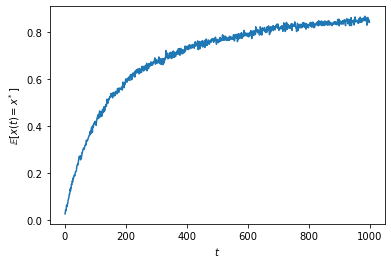

In [5]:
arms_eg, rewards_eg = sim(EpsilonGreedyAgent)
acc = np.mean(arms_eg == Env.opt(), axis=0)  # 시뮬레이션 중에 선택된 솔루션이 최적 솔루션과 일치하는 비율

plt.plot(acc)
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.show()

In [6]:
#전지전능한 에이전트 구현
class OracleAgent(object):
    def __init__(self):
        self.arm = Env.opt()
        
    def get_arm(self):
        return self.arm
    
    def sample(self, arm, reward):
        pass

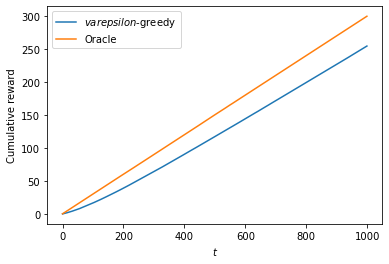

In [7]:
# 전지전능한 에이전트와 epsilon-greedy 알고리즘으로 구현한 에이전트 간의 차이
# 이 누적 보상의 차이가 후회에 해당.

arms_o, rewards_o = sim(OracleAgent)
plt.plot(np.mean(np.cumsum(rewards_eg, axis=1), axis=0),
        label=r'$varepsilon$-greedy')
plt.plot(np.mean(np.cumsum(rewards_o, axis=1), axis=0), label=r'Oracle')
plt.xlabel(r'$t$')
plt.ylabel('Cumulative reward')
plt.legend()
plt.show()

In [8]:
# 탐색 초반에는 다양한 선택지를 시험해 정보를 얻지만 후반에는 활용 행동으로 이동하는 것이 좋음.
# 이러한 알고리즘 기법의 하나가 시뮬레이티드 어닐링

class AnnealingEpsilonGreedyAgent(object):
    
    
    def __init__(self, epsilon=1.0):
        self.epsilon = epsilon
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
    
    def get_arm(self):
        if np.random.random() < self.epsilon:
            arm = np.random.randint(n_arms)
        else:
            arm = np.argmax(self.values)
        self.epsilon *= 0.99    
        # 큰 초깃값을 탐색확률 epsilon으로 설정 => get_arm이 호출될 때마다 0.99를 곱해서 점점 작게(냉각) 만듬.
        # 이를 통해 처음에는 탐색 중심의 행동을 취하고 점점 활용 중심으로 이동
        return arm
    
    def sample(self, arm, reward):
        self.counts[arm] += 1
        self.values[arm] = (
            (self.counts[arm] - 1) * self.values[arm] + reward
            ) / self.counts[arm]
    

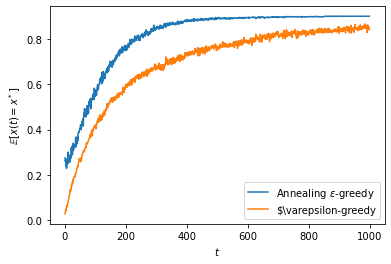

In [9]:
arms_aeg, rewards_aeg = sim(AnnealingEpsilonGreedyAgent)
plt.plot(np.mean(arms_aeg == Env.opt(), axis=0),
        label=r'Annealing $\varepsilon$-greedy')
plt.plot(np.mean(arms_eg == Env.opt(), axis=0), label=r'$\varepsilon-greedy')
plt.xlabel(r'$t$')
plt.ylabel(r'$\mathbb{E}[x(t) = x^*]$')
plt.legend()
plt.show()

In [ ]:
# 슬롯머신 알고리즘을 사용해 실험 기간 중 (1<=t<=T)의 누적 보상이 최대가 되게 할 것
# 그 결과 기댓값이 가장 크다고 추정되는 안 x^*(T)를 실험 후 채택.